# Forex Prediction-04 (Sequence Models + Plot)

What's new:

1- Using app with enter data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:

df = pd.read_csv('datasets/XAGUSD-H1-rates.csv', sep='\t').dropna()

# Scale selected features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
FORECAST_HORIZON = 10
X, y = create_sequences(scaled, df['<CLOSE>'].values, WINDOW_SIZE, FORECAST_HORIZON)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Build basic LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(FORECAST_HORIZON)
])
model.compile(optimizer='adam', loss='mse')


# Train
model.fit(X_train, y_train, epochs=1, verbose=1)

I0000 00:00:1746718610.254926    8177 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2294 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   1/1377 ━━━━━━━━━━━━━━━━━━━━ 32:04 1s/step - loss: 392.5183

I0000 00:00:1746718612.210586    8225 cuda_dnn.cc:529] Loaded cuDNN version 90800


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 129.1096


In [4]:
# === Load the last 30 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets/new-data-for-test/rows-30-from-20240503/rows-30-from-20240503.csv', sep='\t').dropna()
input_scaled = scaler.transform(input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 30, 5)

# === Predict the next 10 candles ===
prediction = model.predict(input_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


# plot section

In [7]:
from utils import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets/new-data-for-test/rows-30-from-20240503/latest-30-for-history.csv'
csv3_path = 'datasets/new-data-for-test/rows-30-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-2]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

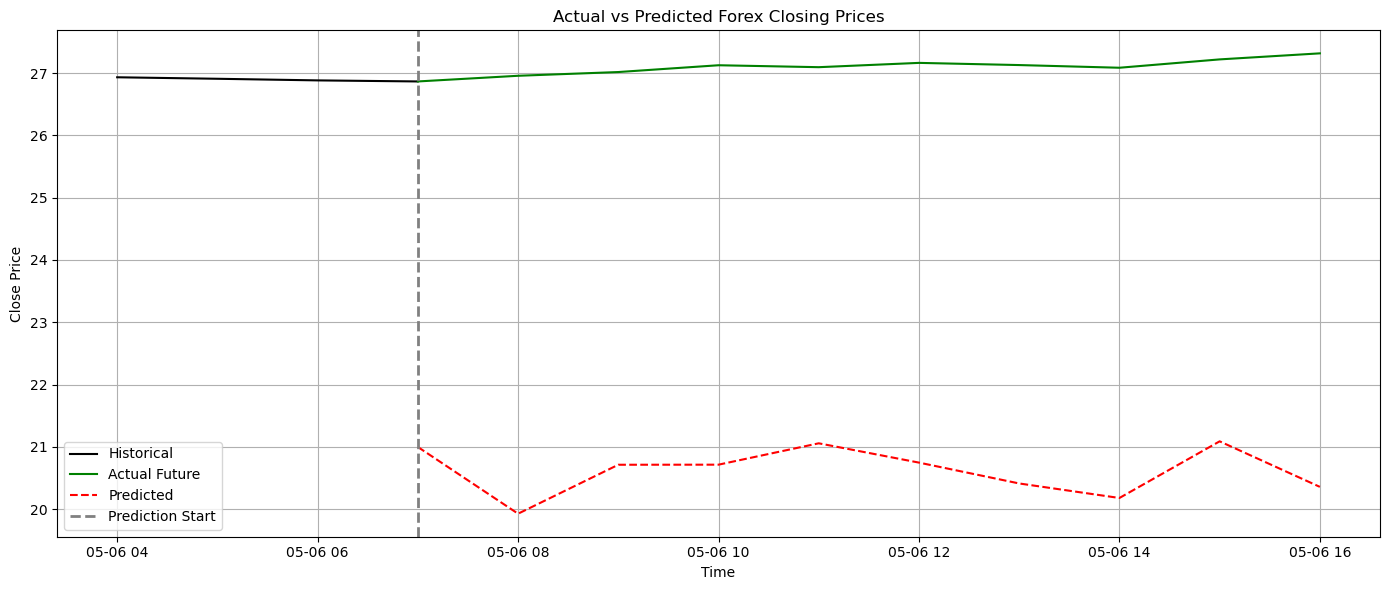

In [8]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)